## model loading and testing

In [1]:
import torch
import joblib
from datetime import datetime
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

from lume_model.utils import variables_from_yaml
from lume_model.models import TorchModel, TorchModule

In [2]:
quads_inj_bctrl = ['QUAD:IN20:121:BCTRL', 'QUAD:IN20:122:BCTRL', 'QUAD:IN20:361:BCTRL', 'QUAD:IN20:371:BCTRL', 
             'QUAD:IN20:425:BCTRL', 'QUAD:IN20:441:BCTRL', 'QUAD:IN20:511:BCTRL', 'QUAD:IN20:525:BCTRL']
quads_linac_bctrl = ['QUAD:LI21:201:BCTRL', 'QUAD:LI21:211:BCTRL', 'QUAD:LI21:221:BCTRL', 'QUAD:LI21:251:BCTRL', 
               'QUAD:LI21:271:BCTRL', 'QUAD:LI21:278:BCTRL', 'QUAD:LI24:740:BCTRL', 'QUAD:LI24:860:BCTRL', 
               'QUAD:LI26:201:BCTRL', 'QUAD:LI26:301:BCTRL', 'QUAD:LI26:401:BCTRL', 'QUAD:LI26:501:BCTRL', 
               'QUAD:LI26:601:BCTRL', 'QUAD:LI26:701:BCTRL', 'QUAD:LI26:801:BCTRL', 'QUAD:LI26:901:BCTRL']
quads_ltuh_bctrl = ['QUAD:LTUH:440:BCTRL', 'QUAD:LTUH:460:BCTRL', 'QUAD:LTUH:620:BCTRL', 'QUAD:LTUH:640:BCTRL', 
              'QUAD:LTUH:660:BCTRL', 'QUAD:LTUH:680:BCTRL']
quads_ltus_bctrl = ['QUAD:LTUS:BCTRL', 'QUAD:LTUS:640:BCTRL', 'QUAD:LTUS:660:BCTRL', 'QUAD:LTUS:680:BCTRL']
quads_all_bctrl = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl
blen = ['BLEN:LI21:265:AIMAX1H', 'BLEN:LI24:886:BIMAX1H']
bcharge = ['SIOC:SYS0:ML00:CALC038', 'SIOC:SYS0:ML00:CALC252'] # at gun, after BC1 # ['BPMS:IN20:221:TMIT1H', 'BPMS:LI21:233:TMIT1H', 'BPMS:LI24:801:TMIT1H'] # at gun, BC1, BC2 
hxr_energy = ['BEND:DMPH:400:BDES','SIOC:SYS0:ML00:AO627'] # beam energy, photon energy
sxr_energy = ['BEND:DMPS:400:BDES','SIOC:SYS0:ML00:AO628']
laser_iris_status = ['IRIS:LR20:130:CONFG_SEL'] # the number of states represents the iris size: 1 [1.8mm], 2 [1.6mm], 3 [1.4mm], 4 [1.2mm], 5 [1.1mm], 6 [1.0mm], 7 [0.8mm]

status_name = ['Bunch length at BC1', 'Bunch length at BC2', 'Charge at gun [pC]', 'Charge after BC1 [pC]', 'HXR electron energy [GeV]', 'HXR photon energy [eV]', 'laser_iris_status']
status_from_archive = blen + bcharge + hxr_energy + laser_iris_status

final_columns = ['timestamp', 'hxr_pulse_intensity'] + quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + status_name

beam_status = ['Charge at gun [pC]', 'Charge after BC1 [pC]', 'HXR electron energy [GeV]',
               'Bunch length at BC1', 'Bunch length at BC2']
input_cols = quads_inj_bctrl + quads_linac_bctrl + quads_ltuh_bctrl + beam_status
output_cols = ['hxr_pulse_intensity']

In [3]:
# Specify the path where files are saved in
model_path = '/sdf/home/z/zihanzhu/lcls/fel_tuning/model/'
model_version = 'model_specific'
loaded_model_path = model_path + model_version + '_lcls_fel_model.pt'
loaded_input_scaler_path = model_path + model_version + '_lcls_fel_input_scaler.pt'
loaded_output_scaler_path = model_path + model_version + '_lcls_fel_output_scaler.pt'

# Load the model state dictionary
model = torch.load(loaded_model_path)

# Load the model state dictionary
input_scaler = torch.load(loaded_input_scaler_path)
output_scaler = torch.load(loaded_output_scaler_path)

## Create a LUME model to wrap input, output transformers and neural network intor TorchModule

In [4]:
# load in- and output variable specification
input_variables, output_variables = variables_from_yaml('/sdf/home/z/zihanzhu/lcls/fel_tuning/pv_variables.yml')

In [5]:
# create TorchModel
lume_model = TorchModel(
    model=loaded_model_path,
    input_variables=input_variables,
    output_variables=output_variables,
    input_transformers=[input_scaler],
    output_transformers=[output_scaler],
)

# or simply load from YAML file
# lume_model = TorchModel("model/sim_model.yml")


In [6]:
# wrap in TorchModule
lume_module = TorchModule(
    model=lume_model,
    input_order=lume_model.input_names,
    output_order=lume_model.output_names,
)

# or simply load from YAML file
# lume_module = TorchModule("model/sim_module.yml")

lume_module

TorchModule(
  (base_model): Sequential(
    (0): Linear(in_features=35, out_features=512, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): ELU(alpha=1.0)
    (8): Linear(in_features=64, out_features=64, bias=True)
    (9): ELU(alpha=1.0)
    (10): Linear(in_features=64, out_features=32, bias=True)
    (11): ELU(alpha=1.0)
    (12): Linear(in_features=32, out_features=32, bias=True)
    (13): ELU(alpha=1.0)
    (14): Linear(in_features=32, out_features=16, bias=True)
    (15): ELU(alpha=1.0)
    (16): Linear(in_features=16, out_features=1, bias=True)
  )
  (input_transformers_0): AffineInputTransform()
  (output_transformers_0): AffineInputTransform()
)

## Test model performance 

In [7]:
# get testing samples from BE during MD on Feb. 1st 
be_dataset = pd.read_pickle('/sdf/home/z/zihanzhu/lcls/fel_tuning/online/BE/20240201/final_data.pkl')

input_data = torch.tensor(be_dataset[input_cols].values)
output_data = torch.tensor(be_dataset[output_cols].values)
final_output = lume_module(input_data)



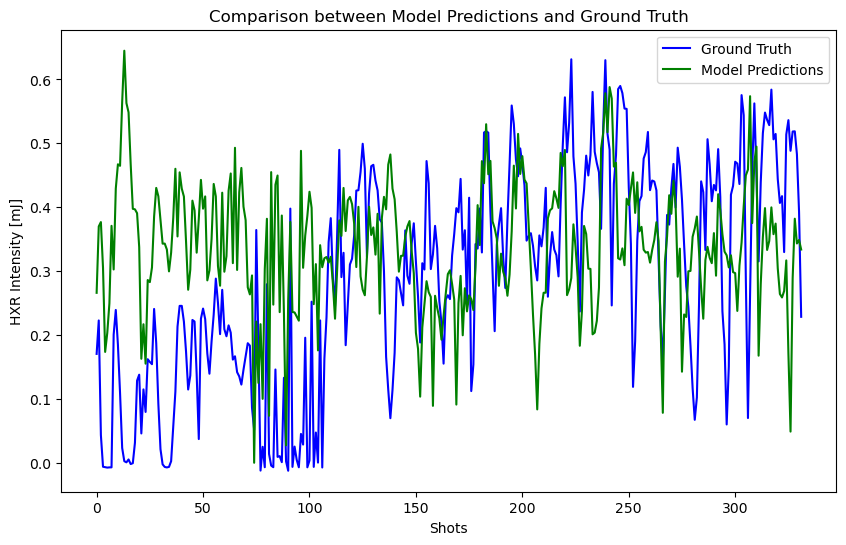

In [9]:
ground_truth = output_data
shot_axis = np.arange(len(ground_truth))

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(shot_axis, ground_truth, label='Ground Truth', color='blue')
plt.plot(shot_axis, final_output, label='Model Predictions', color='green')

plt.title('Comparison between Model Predictions and Ground Truth')
plt.xlabel('Shots')
plt.ylabel('HXR Intensity [mJ]')  # 
plt.legend()

plt.show()